# **Food Sales Predictions Project**

---



Import Libraries and Data Into Dataframe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import category_encoders as ce
import math
filename = '/content/drive/MyDrive/DSDojo/PandasForDataManipulation/sales_predictions.csv'
dfsales = pd.read_csv(filename)

# Data Cleansing

In [3]:
dfsales.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Remove Duplicates

In [4]:
#remove Duplicates if any:
dfsales.duplicated().any()
# No duplicates in data

False

Check for consistent Data Types

In [5]:
dfsales.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
#check for odd data types:
dfsales['Item_Outlet_Sales'].sort_values(ascending = False)
#after looking through each item, no mixed data types were found in any of the columns

Clean Categorical Data

In [7]:
#Check for spelling errors or abbreviations etc in each categorical feature:
dfsales['Outlet_Type'].value_counts()
#Issues only found with one feature

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [8]:
#Issues found with Item Fat Content. Fix below:
dfsales.replace({'Item_Fat_Content':{'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'}}, inplace=True)
# Check with: dfsales['Item_Fat_Content'].value_counts()

In [9]:
# Try to see if missing values can be replaced with logical values if any pattern is identified:
dfsales.info()
#Missing Values found in Item_Weight and Outlet_Size Features
dfsales.groupby(['Outlet_Identifier','Outlet_Size','Outlet_Location_Type'])[['Outlet_Size']].count()
#No pattern Identified for the Outlet_Size nor the Item_Weight features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,,,Outlet_Size
Outlet_Identifier,Outlet_Size,Outlet_Location_Type,
OUT013,High,Tier 3,932
OUT018,Medium,Tier 3,928
OUT019,Small,Tier 1,528
OUT027,Medium,Tier 3,935
OUT035,Small,Tier 2,930
OUT046,Small,Tier 1,930
OUT049,Medium,Tier 1,930


Deal with Missing Values - Part 1: Flag Missing Values

In [ ]:
#Create Flag columns for the missing values:
dfsalesf = dfsales
dfsalesf['No_Item_Weight'] = np.where(dfsalesf['Item_Weight'].isnull(), True, False)
dfsalesf['No_Outlet_Size'] = np.where(dfsalesf['Outlet_Size'].isnull(), True, False)
dfsalesf

In [11]:
#dfsales['Outlet_Size'].value_counts(dropna = False)

Neaten Column Names

In [ ]:
dfsalesf.rename(columns = {'Item_Identifier':'Item_ID', 'Outlet_Identifier':'Outlet_ID', 'Item_Outlet_Sales':'Sales'}, inplace= True)
dfsalesf

Deal with Missing Values - Part 2: Decide how to handle each use case

**Handeling missing data**

***First Analysis*** 

There are too many missing data too use removal as a resolution. 
Data for the outlet size is MAR. There are certain stores where ALL their data for outloet size is missing
Possible solution for outlet size missing values: 1. Create a 'no size indicated' category/feature value 2. impute the mode (most common value). Though this would
be assuming all the stores are the same size... which is a stretch 3. Look into KNN if thats an option here or hot-deck

Data for Item weight is MAR, all weights for items from stores established in 1985 are missing, none are tier 2 adn none of them are from a large outlet
possible solutions. 1. Since we have data for multiple years succeeding 1985, we could consider dropping the values as we should still be able to predict sales values 
in the future using what we have, however, roughly ~1500 (17%) of the data would then be dropped. 2. We could use MICE ti impute the missing data

***Second Analysis*** 

Outlet Size:

The items missing an outliet size are all from certain stores (eg. ALL stores labeled a,b, and c have NO outlet size, but ALL stores labeled d,e, and f HAVE outlet sizes with 0 missing values)

Therefore, excluding them from the analysis would be detrimental to the model as we would be eliminating multiple entire outlets. Since the owner of the business is new and does not know how nor have access to the outlet sizes for the missing records and I dont feel trying to 'guess' the outlet size based on just outlet type and outlet location type would give us accurate results since there - at least at first glance - does not appear to be any relationship between those features and outlet size. My proposed solution is to replace the missing values with a 'Unknown Size' value. That way the information ~2400 observations will not be lost, but will not influence (too much) the results of our final model.

Item Weight:

I noticed that all the item weights for the year 1985 were missing. After consulting with the owner, we agreed that since the desired result for this analysis is to predict food sales in the future, and since we have 9 other years (where outliets were established) to analyze, AND most importantly, since 1985 is the oldest year in our data set, that we can remove all observations from outlets established in the year 1985 without worrying about its impact on our model. This will remove ~1500 observations from our data BUT, we still have ~7000 observations left to work with that is more than sufficient.

After using the below code to check if we have any items without an item weight that are NOT associated with 1985 outlets, we find that there are none. Therefore after these 2 fixes we are done with dealing with the missing data in this dataset.

```
# dfsalesf[(dfsalesf['Outlet_Establishment_Year']!=1985) & (dfsalesf['Item_Weight'] is None)]
```




In [ ]:
#Replace missing outlet size records with 'Unknown Size'
dfSalesFinal = dfsalesf.replace({'Outlet_Size':{None:'Unknown Size'}})
dfSalesFinal

In [ ]:
# check to see if records were replaced correctly:
dfsales['Outlet_Size'].value_counts(dropna = False)

In [ ]:
dfSalesFinal['Outlet_Size'].value_counts(dropna = False)
# 2410 NaNs = 2410 Unknown Size. therefore replacement worked

In [16]:
#Now lets eliminate the observations from 1985 (which are all missing item weights) We could either eliminate all items were establishment year =1985 or drop all null values from item weights. Im going to choose to
# delete records were year = 1985, since that way if I made an error and there are still missing values outside of 1985 that they wont be eliminated by accident AND this way if the dataset is ever updated I wont be 
#deleting new missing values that may come into the item_weight column
dfSalesFinal = dfSalesFinal[dfSalesFinal['Outlet_Establishment_Year']!=1985]
#Our dataset is now ready to work with

#Some simple sample statistics:

In [17]:

#Items with the highest MRP in each type category:
dfSalesFinal.groupby(['Item_Type'])[['Item_ID','Item_MRP']].max()

,Item_ID,Item_MRP
Item_Type,,
Baking Goods,FDZ60,265.5568
Breads,FDZ35,263.2594
Breakfast,FDR37,234.9300
Canned,FDZ49,266.8884
Dairy,FDZ50,266.6884
Frozen Foods,FDZ52,264.8910
Fruits and Vegetables,FDZ56,264.2252
Hard Drinks,DRQ35,261.4278
Health and Hygiene,NCZ53,266.6884


In [18]:
#Average Sales per Outlet:
dfSalesFinal.groupby(['Outlet_ID'])['Sales'].mean().sort_values(ascending = False)

Outlet_ID
OUT035    2438.841866
OUT049    2348.354635
OUT017    2340.675263
OUT013    2298.995256
OUT046    2277.844267
OUT045    2192.384798
OUT018    1995.498739
OUT010     339.351662
Name: Sales, dtype: float64

In [19]:
#Show average Sales per item type over the years
dfSalesFinal.groupby(['Item_Type','Outlet_Establishment_Year'])[['Sales']].mean()

Sales
Item_Type     Outlet_Establishment_Year             
Baking Goods  1987                       2050.901134
              1997                       2281.267334
              1998                        254.605090
              1999                       2110.051342
              2002                       2148.127609
...                                              ...
Starchy Foods 1999                       2471.762918
              2002                       2396.671937
              2004                       3049.784505
              2007                       2438.529489
              2009                       1947.699988

[128 rows x 1 columns]

In [20]:
# Item category giving the most sales in each year
dfSalesFinal.groupby(['Outlet_Establishment_Year'])['Sales','Item_Type','Item_ID'].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Sales,Item_Type,Item_ID
Outlet_Establishment_Year,,,
1987,10256.6490,Starchy Foods,NCZ53
1997,9779.9362,Starchy Foods,NCZ54
1998,1775.6886,Starchy Foods,NCZ54
1999,7646.0472,Starchy Foods,NCZ54
2002,8994.9580,Starchy Foods,NCZ54
2004,8479.6288,Starchy Foods,NCZ42
2007,9664.7528,Starchy Foods,NCZ42
2009,6768.5228,Starchy Foods,NCZ54


In [21]:
# Item category giving the least sales in each year
dfSalesFinal.groupby(['Outlet_Establishment_Year'])['Sales','Item_Type'].min()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Sales,Item_Type
Outlet_Establishment_Year,,
1987,73.2380,Baking Goods
1997,101.8674,Baking Goods
1998,33.2900,Baking Goods
1999,111.8544,Baking Goods
2002,99.8700,Baking Goods
2004,113.8518,Baking Goods
2007,143.8128,Baking Goods
2009,69.2432,Baking Goods


In [22]:
#Number of small, med and large outlets over the years:
dfSalesFinal.groupby(['Outlet_Establishment_Year','Outlet_Size'])['Outlet_Size'].count()

Outlet_Establishment_Year  Outlet_Size 
1987                       High            932
1997                       Small           930
1998                       Unknown Size    555
1999                       Medium          930
2002                       Unknown Size    929
2004                       Small           930
2007                       Unknown Size    926
2009                       Medium          928
Name: Outlet_Size, dtype: int64

In [23]:
#Number of outlet types over the years:
dfSalesFinal.groupby(['Outlet_Establishment_Year','Outlet_Type'])[['Outlet_Type']].count()

,,Outlet_Type
Outlet_Establishment_Year,Outlet_Type,
1987,Supermarket Type1,932
1997,Supermarket Type1,930
1998,Grocery Store,555
1999,Supermarket Type1,930
2002,Supermarket Type1,929
2004,Supermarket Type1,930
2007,Supermarket Type1,926
2009,Supermarket Type2,928


In [24]:
#Total Cumulative sales over the years:
dfsalesff = dfsalesf
#dfsalesff['Outlet_Establishment_Year']= str(dfsalesff['Outlet_Establishment_Year'])
test = dfSalesFinal.groupby(['Outlet_Establishment_Year'])[['Sales']].sum()#.sort_values(ascending = False)
test.cumsum()


,Sales
Outlet_Establishment_Year,
1987,2.142664e+06
1997,4.261059e+06
1998,4.449399e+06
1999,6.633369e+06
2002,8.670094e+06
2004,1.093822e+07
2007,1.310568e+07
2009,1.495751e+07


# EDA
**Histograms**

Text(0, 0.5, 'Count')

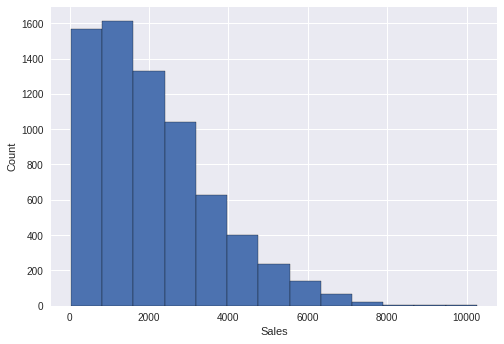

In [25]:
# investigate sales distribution
plt.style.use('seaborn')
dfSalesFinal['Sales'].hist(edgecolor = 'k', bins = 13);
plt.xlabel('Sales')
plt.ylabel('Count')

The distribution of our sales is skewed to the left, with most of our sales falling in the 0-$2000 range (and this is of course total sales per item_ID for each outlet).

Text(0, 0.5, 'Count')

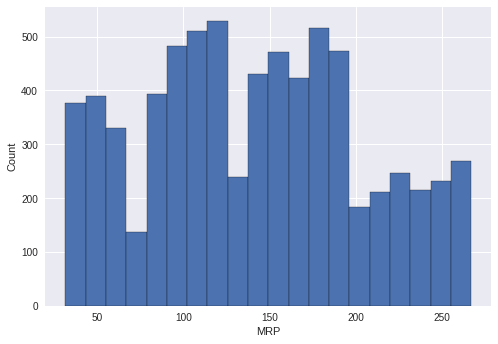

In [26]:
# investigate  MRP distribution
plt.style.use('seaborn')
dfSalesFinal['Item_MRP'].hist(edgecolor = 'k', bins = 20);
plt.xlabel('MRP')
plt.ylabel('Count')

There appears to be a very random distribution of MRPs, though after the 200 mark it appears to remain at a lower frequency rate

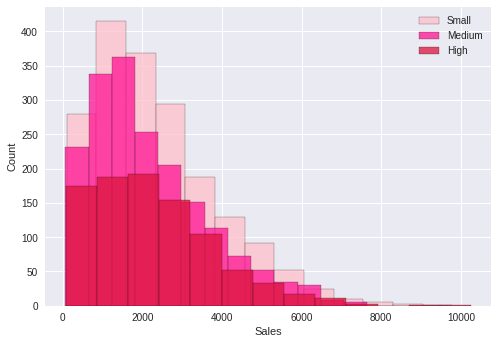

In [27]:
# investigate sales distribution for each Outlet Size
plt.style.use('seaborn')
dfSalesFinal[dfSalesFinal['Outlet_Size']=='Small']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Small', color = 'pink', alpha = .75);
dfSalesFinal[dfSalesFinal['Outlet_Size']=='Medium']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Medium', color = 'deeppink', alpha = .75);
dfSalesFinal[dfSalesFinal['Outlet_Size']=='High']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'High', color = 'crimson', alpha = .75);
plt.xlabel('Sales')
plt.ylabel('Count')
plt.legend()

The distribution of sales for all 3 Outlet sizes is approximately the same, though the amount of sales decreases as outlet size increases

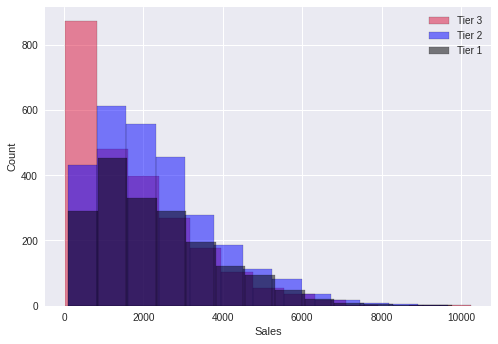

In [28]:
# investigate sales distribution for each Outlet Location Type
plt.style.use('seaborn')
dfSalesFinal[dfSalesFinal['Outlet_Location_Type']=='Tier 3']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Tier 3', color = 'crimson', alpha = .5);
dfSalesFinal[dfSalesFinal['Outlet_Location_Type']=='Tier 2']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Tier 2', color = 'blue', alpha = .5);
dfSalesFinal[dfSalesFinal['Outlet_Location_Type']=='Tier 1']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Tier 1', color = 'k', alpha = .5);


plt.xlabel('Sales')
plt.ylabel('Count')
plt.legend()

Sales for tier 1 and tier 2 locations follow a similar distribution though tier 1 has a lower amount of sales overall. The sales for the Tier 3 follow a slightly different distribution in that they have a very large volume of lower sales (~ < 1000), however after this 'anomaly' it follows a similar distribution to the other location tiers.

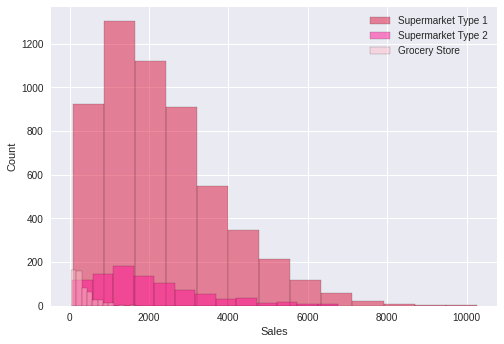

In [29]:
# investigate sales distribution for each Outlet Location Type
plt.style.use('seaborn')
dfSalesFinal[dfSalesFinal['Outlet_Type']=='Supermarket Type1']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Supermarket Type 1', color = 'crimson', alpha = .5);
dfSalesFinal[dfSalesFinal['Outlet_Type']=='Supermarket Type2']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Supermarket Type 2', color = 'deeppink', alpha = .5);
dfSalesFinal[dfSalesFinal['Outlet_Type']=='Grocery Store']['Sales'].hist(edgecolor = 'k', bins = 13, label = 'Grocery Store', color = 'pink', alpha = .5);


plt.xlabel('Sales')
plt.ylabel('Count')
plt.legend()

Supermarket Type 1 has a extremly high count compared to the other types of outlet types all 3 distributions are skewed to the left, but Supermarket type 2 slightly less so than the other 2. Grocery Stores have a very low amount of sales and those sales all fall in a very low sales amount bracket.

**boxplots - comparing statistical summaries**

In [ ]:
# Lets compare sales for each Outlet type:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
listoutlet = dfSalesFinal['Outlet_ID'].unique()
plotme = []
for index in listoutlet:
  plotme.append(dfSalesFinal[dfSalesFinal['Outlet_ID']==index]['Sales'])

boxplotsvar = axes.boxplot(plotme,widths = .25,patch_artist= True, notch = True, labels = listoutlet, showmeans = True, meanprops={"marker":'X', "markerfacecolor":'white', "markeredgecolor": 'k'})
plt.ylabel("Sales", fontsize = 13)

#show meass: https://stackoverflow.com/questions/29777017/show-mean-in-the-box-plot-in-python

OUT10's IQR, mean, median, max and min are all lower than the Q1's of all the other Outlets. Otherwise the rest of the outlets have very similar spreads and have medians that are all on or near the \$2000 mark. All outlets have a minimum sales value close to zero, and with the exception of OUT10 and OUT18 they all have maximums very close to the \$6000 mark.Outlets OUT13, OUT45, OUT17, OUT46, OUT35 have outliers over a longer sales range than the other outlets. The means of all Outlets (besides OUT10) are also very similar. Overall, the outlets dont appear to differ much in sales from one to another, with the exception of OUT10 which happens to be a grocery store wich probably is the reason why its sales are so much lower.

In [ ]:
# Lets compare sales with regards to the Outlet Establishment Year:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
listYear = dfSalesFinal['Outlet_Establishment_Year'].unique()
plotmeYearSales = []
for index in listYear:
  plotmeYearSales.append(dfSalesFinal[dfSalesFinal['Outlet_Establishment_Year']==index]['Sales'])

boxplotsvar = axes.boxplot(plotmeYearSales,widths = .25,patch_artist= True, notch = True, labels = listYear, showmeans = True, meanprops={"marker":'X', "markerfacecolor":'white', "markeredgecolor": 'k'})
plt.ylabel("Sales", fontsize = 13)

#show meass: https://stackoverflow.com/questions/29777017/show-mean-in-the-box-plot-in-python

The data does not differ from the previous visual. After some digging I found that this is because only one outlet was established per year.

# Data Visualization (and some more EDA)

We will now plot some simple graphs to identify any trends, patterns, correclations or oddeties in the data.

In [ ]:
#Lets look at any correlation between qualitative data features:

#Define all variables:

iWeight = dfSalesFinal['Item_Weight']
iSales = dfSalesFinal['Sales']
iVis = dfSalesFinal['Item_Visibility']
iMRP = dfSalesFinal['Item_MRP']

#plot 1: Item weight vs sales

#plot 2: item weightvs Item MRP

#plot 3: item weight vs Item Visibility

#plot 4: Item MRP vs Sales

#plot 5: Item Visibility vs sales

#plot 6 Item MRP vd Item Visibility
plt.figure(figsize = (25,25))
plt.style.use('seaborn')
plt.subplot(3,2,1)
plt.title("Item Weight vs Sales Amount",fontsize = 20)
plt.xlabel('Item Weight',fontsize = 15)
plt.ylabel('Sales Income',fontsize = 15)
plt.scatter(iWeight,iSales)

plt.subplot(3,2,2)
plt.title("Item Weight vs Item MRP",fontsize = 20)
plt.xlabel('Item Weight',fontsize = 15)
plt.ylabel('Item MRP',fontsize = 15)
plt.scatter(iWeight,iMRP)

plt.subplot(3,2,3)
plt.title("Item Weight vs Item Visibility",fontsize = 20)
plt.xlabel('Item Weight',fontsize = 15)
plt.ylabel('Item Visibility',fontsize = 15)
plt.scatter(iWeight,iVis)

plt.subplot(3,2,4)
plt.title("Sales vs Item MRP",fontsize = 20)
plt.xlabel('Item MRP',fontsize = 15)
plt.ylabel('Sales',fontsize = 15)
plt.scatter(iMRP,iSales)

plt.subplot(3,2,5)
plt.title("Sales vs Item Visibility",fontsize = 20)
plt.xlabel('Item Visibility',fontsize = 15)
plt.ylabel('Sales',fontsize = 15)
plt.scatter(iVis,iSales)

plt.subplot(3,2,6)
plt.title("Item MRP vs Item Visibility",fontsize = 20)
plt.xlabel('Item Visibility',fontsize = 15)
plt.ylabel('Item MRP',fontsize = 15)
plt.scatter(iVis,iMRP)

**Findings From Scatter Plots**

Item weight vs sales:
There is no correlation between Item Weight and Sales, though Sales seems to teeter off at some point this is natural as in a supermarket/grocery store you will have way more low cost items then high cost, that has nothing to do with Item Weight

item weight vs Item MRP: Absolutely no correlation

item weight vs Item Visibility: There is no correlation between features. At best there is a low linear correlation. Logically though there is no relationship between an items weight and its visibility, we can see that for all weights we have a wide distribution of items that are both more and less visible


Item MRP vs Sales: There seems to be a low (loose) positive linear correlation between sales and MRP. Though it seems that the higher the sales are the more likely we are to have a stronger (higher) positive linear correlation bewteen the 2 features. This seems logical as the higher priced an item (priced at the MRP limit) the more likely it is to generate more sales revenue if sold, however, just because an item is priced at a higher MRP does not guarentee a sale, which can explain why we have values with varying sales for high MRPs. Conversley, an item with a low MRP can only generate so much revenue, which is why we dont see items with low MRPs in the higher sales brackets.

Item Visibility vs sales: There is a low, loose negative linear correlation between item visibility and sales. This seems to almost be counter intuitive. One would think that the more visible the item is the more likely it is to get sold, however the graph seems to initially indicate otherwise, in that the more visible an item the less likely to gross a higher amount of sales.
Possible reasons could be that when it comes to higher priced items people typically go in knowing what they are looking for, regardless of how much space is given to a displayed item. For example, a person could enter a store with the intention to buy a certain item and go directly to that area, perhaps even asking for the item by name without the need to search for it. Another reason could be that higher priced items may not need to be displayed multiple times, for example, you only need to display one cellphone to sell multiple cellphones, since the dummy model stays on display, unlike having an isle full of bread loaves. Another reason this may occur is that low visibility may give the illusion that an item is in high demand. If I go to the store and a certain brand of chocolate is either sold out or only seems to have a few bars left, it may give the illusion that this item is highly valued by others and may make me want it more and more likely to pay higher prices when I do see it. I'll want to purchase it before it runs out again. Lastly, it may not be cost effective for a store to stock and display high cost, perishable items. People may prefer cheaper alternatives and the high cost items - if displayed in bulk - could persish before being sold, resulting in a loss for the store. It would be better to stock only a few high cost items and sell out, then lose out.It is interesting to note that although there is a lose negative relationship between these variables, that there comes a point were when an item exceeds about 0.18 visibility, that relationship disappears altogther.

Item MRP vd Item Visibility: No correlation of note

**Let's try visualize some of these with heatmaps**

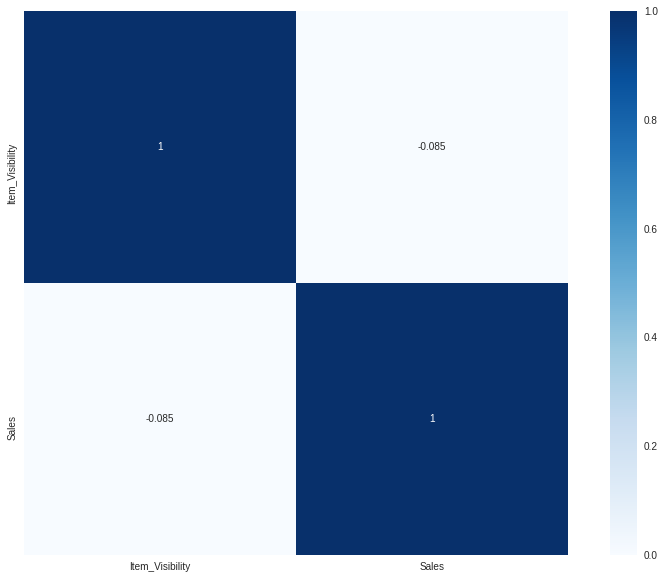

In [33]:
#Lets do a heat map of item visibility vs Sales
dfcorrVvS = dfSalesFinal.loc[:,['Item_Visibility','Sales']]
vns = dfcorrVvS.corr()
xvns= vns.iloc[0].values
yvns= vns.iloc[1].values
arrayvns = [xvns,yvns]
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(arrayvns,cmap="Blues", annot = True, xticklabels= vns.iloc[0].index, yticklabels=vns.iloc[1].index, square = True, vmin = 0, vmax = 1)

This verifies that there is a very very loose negative correlation between sales and item visibility

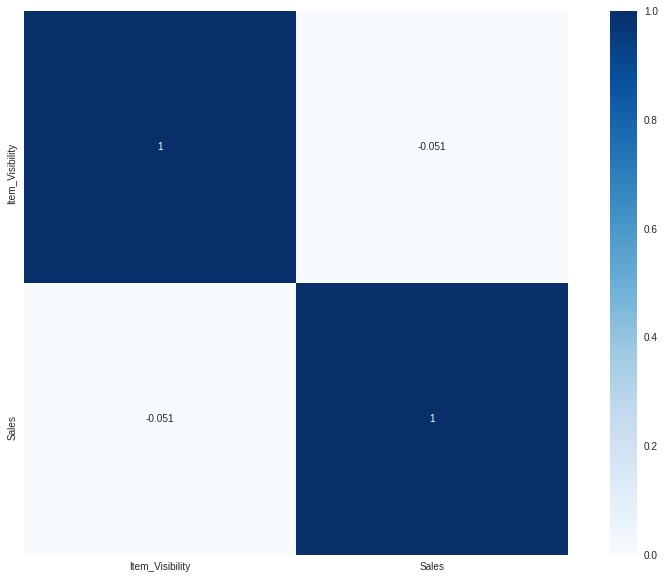

In [34]:
#Lets do a heat map of item visibility vs Sales for visibility < 0.20
dfcorrVvS2 = dfSalesFinal[dfSalesFinal['Item_Visibility']<0.2].loc[:,['Item_Visibility','Sales']]
vns2 = dfcorrVvS2.corr()
xvns2= vns2.iloc[0].values
yvns2= vns2.iloc[1].values
arrayvns2 = [xvns2,yvns2]
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(arrayvns2,cmap="Blues", annot = True, xticklabels= vns2.iloc[0].index, yticklabels=vns2.iloc[1].index, square = True, vmin = 0, vmax = 1)

I presumed cutting out sales where visibility is <.2 would result in a slightly higher correlation but I was incorrect. I'm not sure why this is and need to think further on this - will come back to this later

answer: The loose data after.2 actually helps pull the overall correlation up as its very low down so it helps the data to have a more negative trend. removing it makes the rest of the data points have a more linear trend since they have no datapoints to pull the trend downwards

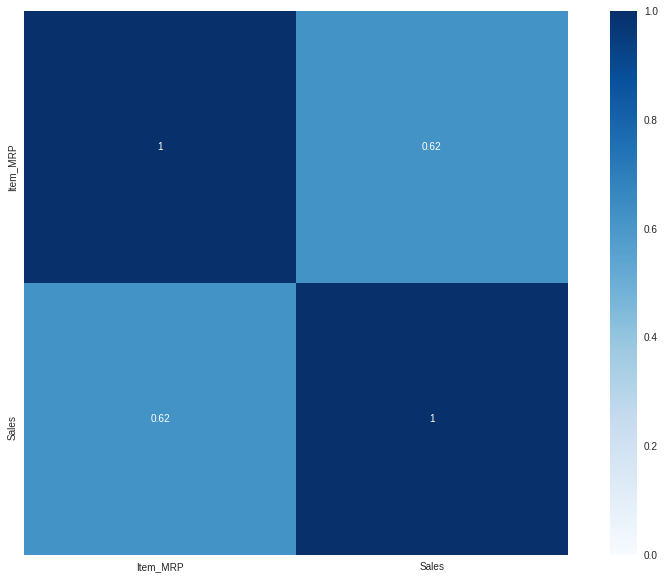

In [35]:
#Lets do a heat map of MRP vs Sales
dfcorrMvS = dfSalesFinal.loc[:,['Item_MRP','Sales']]
mns = dfcorrMvS.corr()
xmns= mns.iloc[0].values
ymns= mns.iloc[1].values
arraymns = [xmns,ymns]
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(arraymns,cmap="Blues", annot = True, xticklabels= mns.iloc[0].index, yticklabels=mns.iloc[1].index, square = True, vmin = 0, vmax = 1);


Again, as confirmed in the previous correlation plots, there is a low-moderate positive linear correlation between MRP and sales, the correlation is stronger the higher sales gets

**More Visualizations**

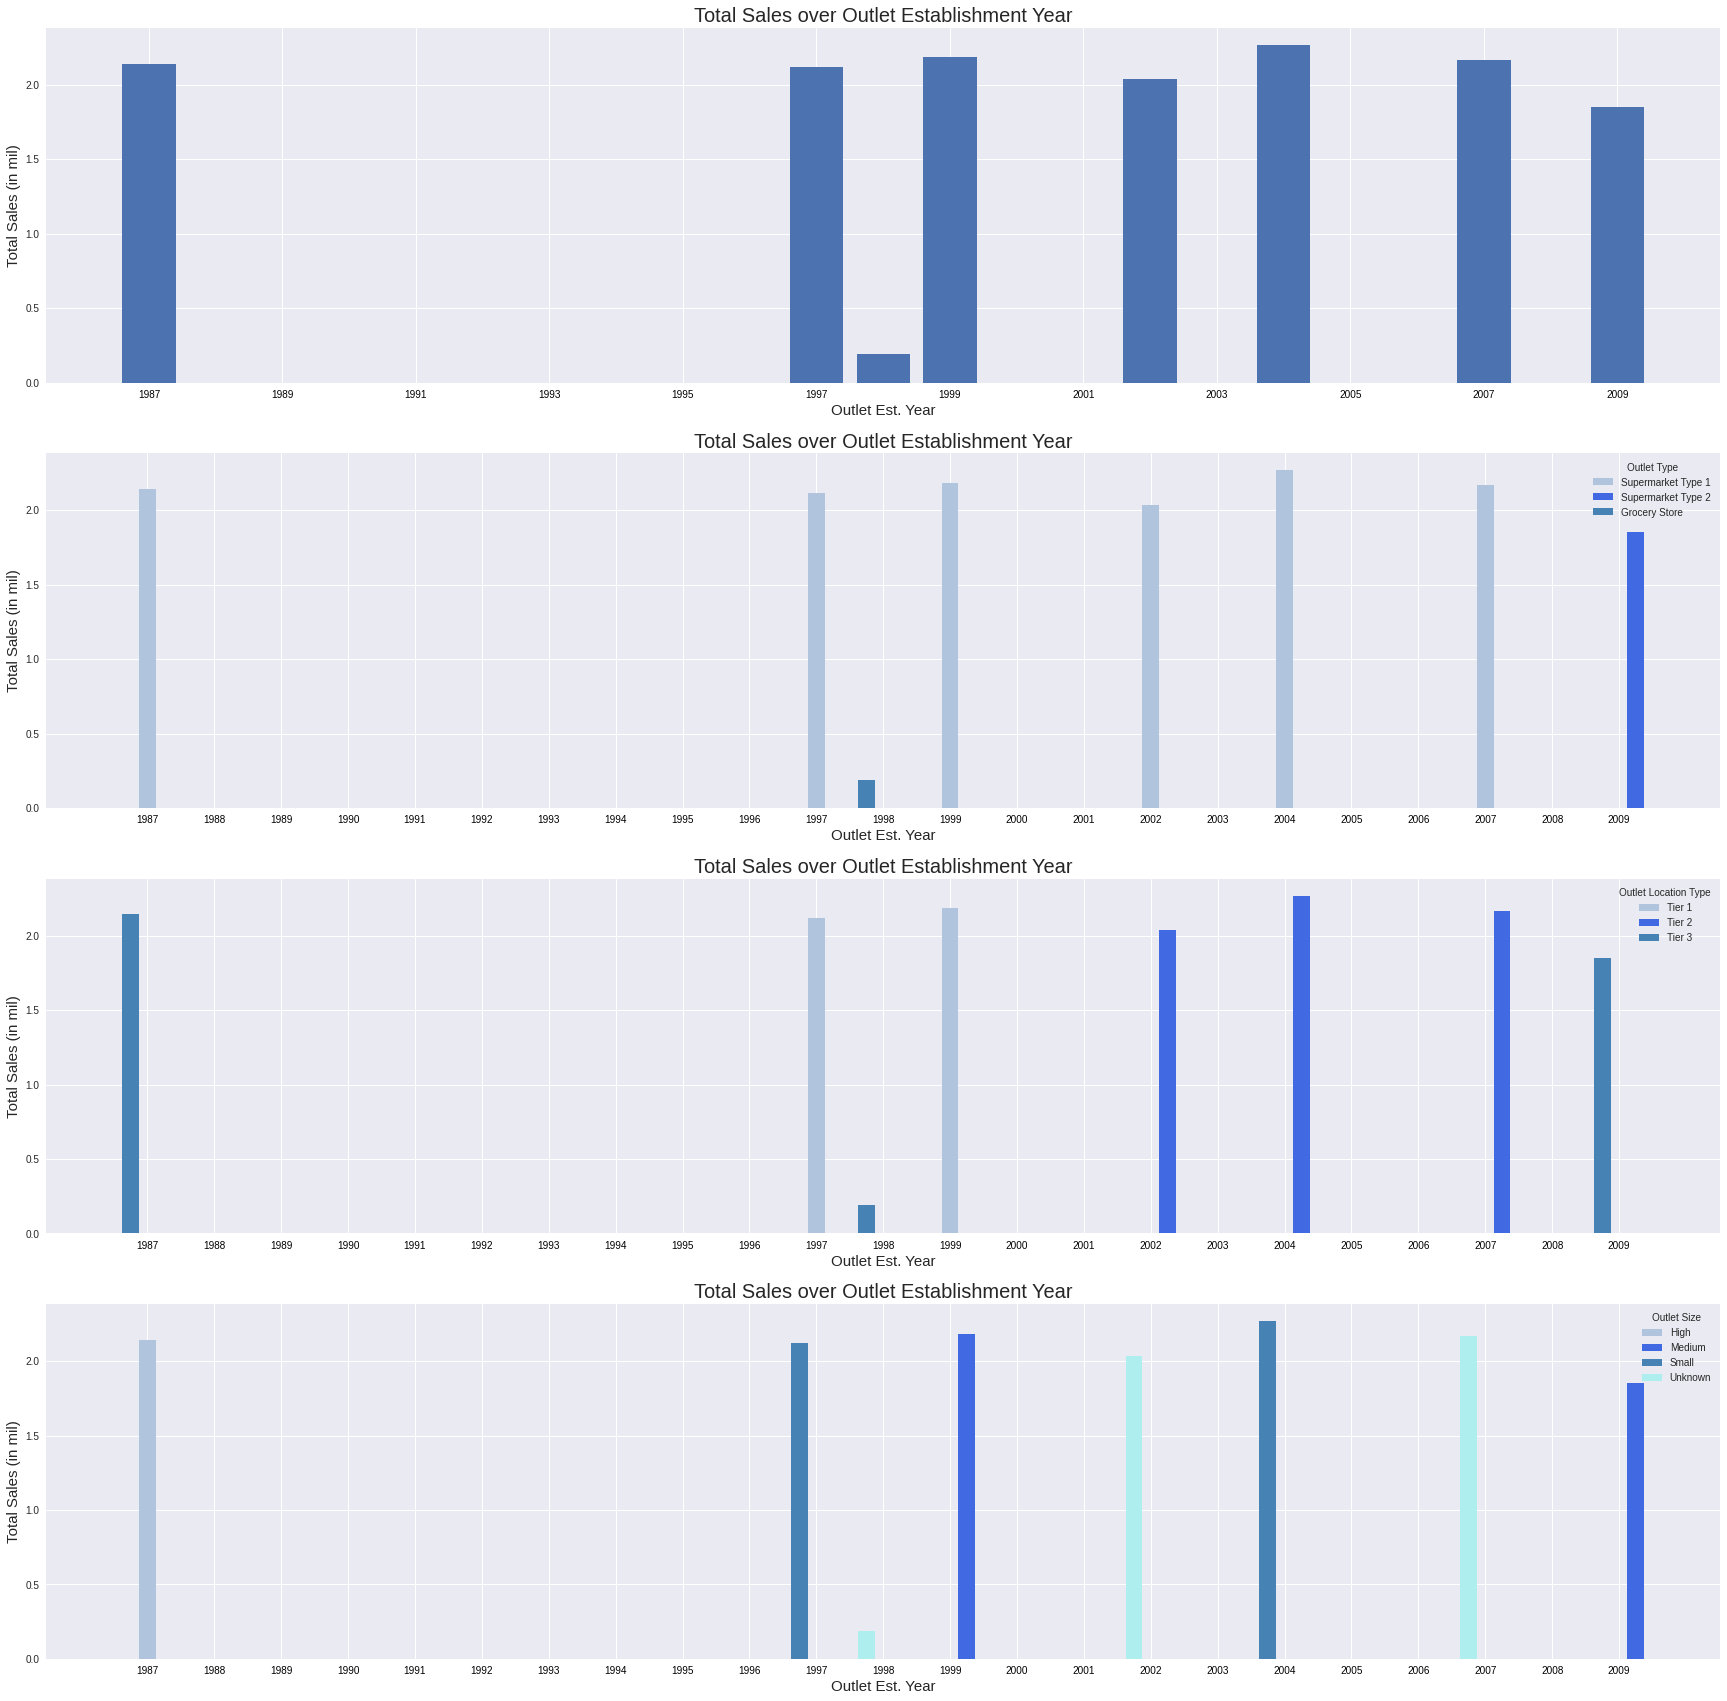

In [36]:
# See sales over time (year outlet was established)
#Declare variables:
#plot 1: Sales over time
salespyear = dfSalesFinal.groupby('Outlet_Establishment_Year')['Sales'].sum()
#plot 2 Sales over time by Outlet Type
dfSalesOT = dfSalesFinal.groupby(['Outlet_Establishment_Year','Outlet_Type'])[['Sales']].sum().unstack(fill_value = 0)
dfSalesOT.columns=['Grocery_Store_Sales','Supermarket_Type1_Sales','Supermarket_Type2_Sales']
salespyearST1 = dfSalesOT['Supermarket_Type1_Sales']
salespyearST2 = dfSalesOT['Supermarket_Type2_Sales']
salespyearG = dfSalesOT['Grocery_Store_Sales']
# salespyearST1 = dfSalesFinal[dfSalesFinal['Outlet_Type']=='Supermarket Type1'].groupby('Outlet_Establishment_Year')['Sales'].sum()
# salespyearST2 = dfSalesFinal[dfSalesFinal['Outlet_Type']=='Supermarket Type2'].groupby('Outlet_Establishment_Year')['Sales'].sum()
# salespyearG = dfSalesFinal[dfSalesFinal['Outlet_Type']=='Grocery Store'].groupby('Outlet_Establishment_Year')['Sales'].sum()

#plot 3:  Sales over time by outlet Location Type
# dfSalesLT = dfSalesFinal.groupby(['Outlet_Establishment_Year','Outlet_Location_Type'])[['Sales']].sum().unstack(fill_value = 0)
# dfSalesLT.columns=['Tier1_Sales','Tier2_Sales','Tier3_Sales']
dfmissing = pd.DataFrame([[1988,0,0,0],[1989,0,0,0],[1990,0,0,0],[1991,0,0,0],[1992,0,0,0],[1993,0,0,0],[1994,0,0,0],[1995,0,0,0],[1996,0,0,0],[2000,0,0,0],[2001,0,0,0],[2003,0,0,0],[2005,0,0,0],[2006,0,0,0],[2008,0,0,0]],columns=['Outlet_Establishment_Year','Tier1_Sales','Tier2_Sales','Tier3_Sales' ])
dfSalesLT = dfSalesFinal.groupby(['Outlet_Establishment_Year','Outlet_Location_Type'])[['Sales']].sum().unstack(fill_value = 0).reset_index()
dfSalesLT.columns=['Outlet_Establishment_Year','Tier1_Sales','Tier2_Sales','Tier3_Sales']
dfSalesLTA = dfSalesLT.append(dfmissing).reset_index().sort_values(by='Outlet_Establishment_Year')
salespyearLT1 = dfSalesLTA['Tier1_Sales']
salespyearLT2 = dfSalesLTA['Tier2_Sales']
salespyearLT3 = dfSalesLTA['Tier3_Sales']

#plot 4: Sales over time by Outlet size
dfSalesOS = dfSalesFinal.groupby(['Outlet_Establishment_Year','Outlet_Size'])[['Sales']].sum().unstack(fill_value = 0)
dfSalesOS.columns=['High_Sales','Medium_Sales','Small_Sales','Unknown_Size_Sales']
salespyearOS1 = dfSalesOS['High_Sales']
salespyearOS2 = dfSalesOS['Medium_Sales']
salespyearOS3 = dfSalesOS['Small_Sales']
salespyearOS4 = dfSalesOS['Unknown_Size_Sales']



margin = 0.05
# width = (1.-2*margin)/len(nrange)
w = 0.25
nrange = np.arange(0,len(np.arange(min(salespyear.index),max(salespyear.index)+1,2)), 1)
nindex = np.arange(len(nrange))
plt.figure(figsize = (30,30))
plt.style.use('seaborn')
plt.subplot(4,1,1)
plt.xticks(np.arange(min(salespyear.index),max(salespyear.index)+1,2), c = 'k')
plt.title("Total Sales over Outlet Establishment Year",fontsize = 20)
plt.xlabel('Outlet Est. Year',fontsize = 15)
plt.ylabel('Total Sales (in mil)',fontsize = 15)
plt.bar(salespyear.index,salespyear.values/1_000_000,)
#----------------------------------------------------------------------------------
nrangeMain = np.arange(0,len(np.arange(min(dfSalesLTA.index),max(dfSalesLTA.index)+1,1)), 1)
nindexMain = np.arange(len(nrangeMain))
plt.subplot(4,1,2)
plt.title("Total Sales over Outlet Establishment Year",fontsize = 20)
plt.xlabel('Outlet Est. Year',fontsize = 15)
plt.ylabel('Total Sales (in mil)',fontsize = 15)
plt.xticks(np.arange(min(salespyear.index),max(salespyear.index)+1,1), c = 'k')
plt.bar(dfSalesOT.index ,salespyearST1/1_000_000, width = w, label = "Supermarket Type 1", color = 'lightsteelblue')
plt.bar(dfSalesOT.index + w,salespyearST2/1_000_000, label = "Supermarket Type 2", color = 'royalblue', width = w)
plt.bar(dfSalesOT.index - w,salespyearG/1_000_000, label = "Grocery Store", color = 'steelblue', width = w)
plt.legend(title = 'Outlet Type')
#-----------------------------------------------------------------------------------
plt.subplot(4,1,3)
plt.title("Total Sales over Outlet Establishment Year",fontsize = 20)
plt.xlabel('Outlet Est. Year',fontsize = 15)
plt.ylabel('Total Sales (in mil)',fontsize = 15)
labelsLTA = dfSalesLTA['Outlet_Establishment_Year'].sort_values()
plt.xticks(np.arange(min(dfSalesLTA.index),max(dfSalesLTA.index)+1,1), c = 'k', labels = labelsLTA)
# plt.xticks(np.arange(len(dfSalesLTA['Outlet_Establishment_Year'])), c = 'k')#, labels = labelsLTA)
plt.bar(np.arange(len(dfSalesLTA['Outlet_Establishment_Year'])),salespyearLT1/1_000_000, width = w, label = "Tier 1", color = 'lightsteelblue', align = 'center')
plt.bar(np.arange(len(dfSalesLTA['Outlet_Establishment_Year'])) + w,salespyearLT2/1_000_000, label = "Tier 2", color = 'royalblue', width = w, align = 'center')
plt.bar(np.arange(len(dfSalesLTA['Outlet_Establishment_Year'])) - w,salespyearLT3/1_000_000, label = "Tier 3", color = 'steelblue', width = w, align = 'center')
plt.legend(title = 'Outlet Location Type')
#----------------------------------------------------------------------------------
plt.subplot(4,1,4)
plt.title("Total Sales over Outlet Establishment Year",fontsize = 20)
plt.xlabel('Outlet Est. Year',fontsize = 15)
plt.ylabel('Total Sales (in mil)',fontsize = 15)
plt.xticks(np.arange(min(salespyear.index),max(salespyear.index)+1,1), c = 'k')
plt.bar(dfSalesOT.index ,salespyearOS1/1_000_000, width = w, label = "High", color = 'lightsteelblue')
plt.bar(dfSalesOT.index + w,salespyearOS2/1_000_000, label = "Medium", color = 'royalblue', width = w)
plt.bar(dfSalesOT.index - w,salespyearOS3/1_000_000, label = "Small", color = 'steelblue', width = w)
plt.bar(dfSalesOT.index - w,salespyearOS4/1_000_000, label = "Unknown", color = 'paleturquoise', width = w)
plt.legend(title = 'Outlet Size', loc = "upper right")
#-----------------------------------------------------------------------------------

**Findings concerning years outlets were established**

There seems to be no apparent relationship between the size, type or location of outlets and their associated sales, with regards to the years they were opened. The only observation worth noting is the consistent plunge in sales in 1998. This may be due to the Dow Jones plummeting over 500 points that year. For more info see
[here:](https://money.cnn.com/1998/08/31/markets/marketwrap/)

Outlets in Location Tier 2 do seem to have more sales than other locations, however there are also more outlets than tier 1 and they were build more recently than tier 3 - they are also all of supermarket type 1. All these facts together may contribute to larger sales and not just Location Tier individually

([<matplotlib.axis.XTick at 0x7f20cc206bd0>,
 [Text(0, 0, 'Grocery Store'),
  Text(0, 0, 'Supermarket Type1'),
  Text(0, 0, 'Supermarket Type2')])

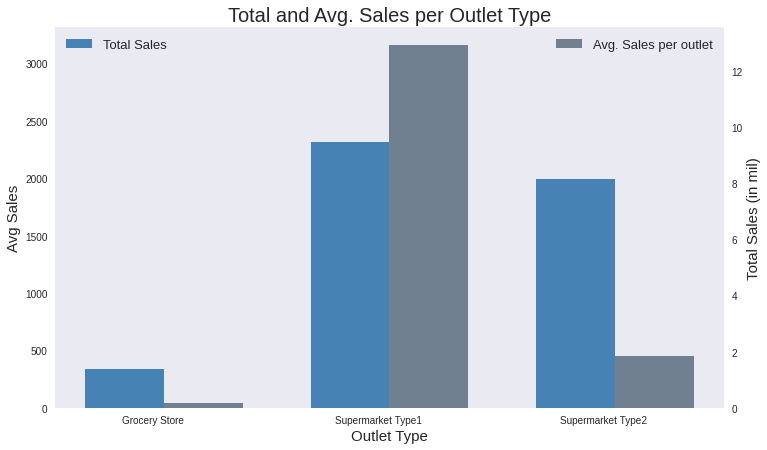

In [37]:
ww = .35
fig,ax = plt.subplots(figsize = (12,7))
ax.grid(False)
OTAvg = dfSalesFinal.groupby(['Outlet_Type'])['Sales'].mean()
OTTot = dfSalesFinal.groupby(['Outlet_Type'])['Sales'].sum()/1_000_000

ax.set_xlabel('Outlet Type',fontsize = 15)
ax.set_ylabel('Avg Sales',fontsize = 15)
ax.bar(np.arange(len(OTAvg.index)),OTAvg.values, color = 'steelblue', label = 'Total Sales', width = ww, align = 'center')
ax.set_ylim(0,OTAvg.max() + 1000)

ax2 = ax.twinx()
ax2.set_ylabel('Total Sales (in mil)',fontsize = 15)
ax2.grid(False)
ax2.bar(np.arange(len(OTAvg.index)) + ww,OTTot.values, color = 'slategrey', label = 'Avg. Sales per outlet', width = ww)

ax.legend(loc='upper left', facecolor = "k", fontsize = 13)
ax2.legend(loc='best', facecolor = "k", fontsize = 13)
plt.title("Total and Avg. Sales per Outlet Type",fontsize = 20)
plt.xticks(np.arange(len(OTAvg.index)) + w/2, c = 'k', labels = list(OTAvg.index))

**Other**

Even though Supermarket type 1 grosses the most sales by far, once we take the average sales per outlet of each type, the difference between type 1 and type 2 are greatly reduced, though type 1 still trumps type 2

**Evaluating Outlets Individually**

<BarContainer object of 8 artists>

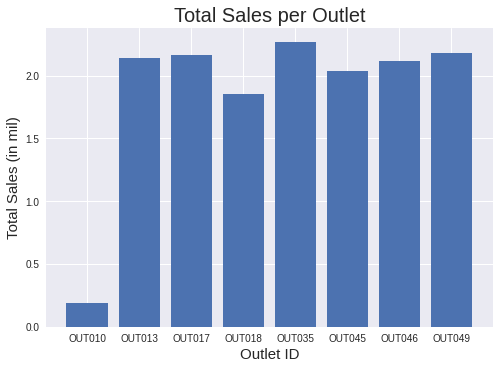

In [38]:
#decalre vars:
OutSales = dfSalesFinal.groupby(['Outlet_ID'])[['Sales']].sum()/1_000_000
#plot
plt.title("Total Sales per Outlet",fontsize = 20)
plt.xlabel('Outlet ID',fontsize = 15)
plt.ylabel('Total Sales (in mil)',fontsize = 15)
plt.bar(OutSales.index,OutSales['Sales'])

**Findings Concering Individual Outlets**

Sales for all outlets seem consistent, except for outlet OUT010. It is interesing to not that OUT010 did not have an outlet size indicated, and is the only outlet that is of the 'grocery store' type. It is possible that this store had low sales due to its type. Grocery stores may be smaller and carry less stock.

**Evaluating Sales by Item Features**

<BarContainer object of 10 artists>

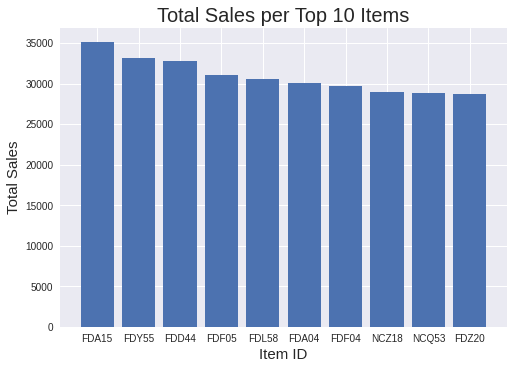

In [39]:
#WOverall top 10 items
#decalre vars:
ITSales = dfSalesFinal.groupby(['Item_ID'])[['Sales']].sum()
ITSales = ITSales.sort_values(by = 'Sales',ascending = False).head(10)
#plot
plt.title("Total Sales per Top 10 Items",fontsize = 20)
plt.xlabel('Item ID',fontsize = 15)
plt.ylabel('Total Sales',fontsize = 15)
plt.bar(ITSales.index,ITSales['Sales'])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

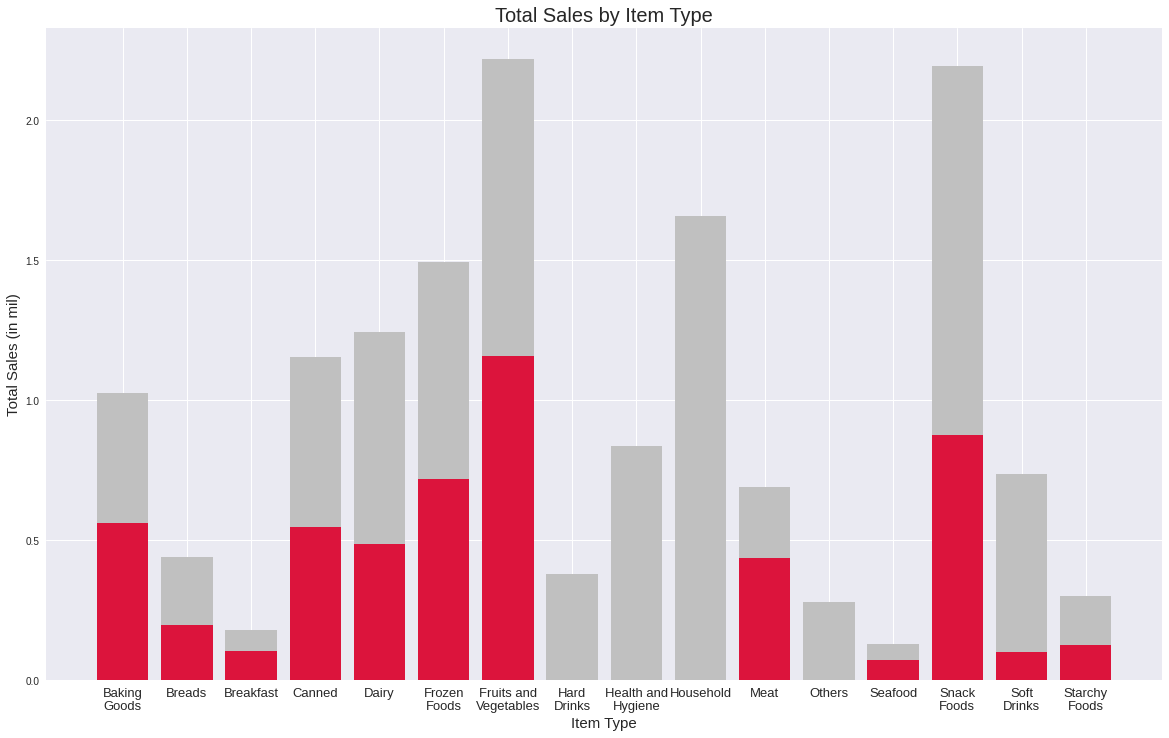

In [40]:
#by category
#decalre vars:
ITTypeSalesfat = dfSalesFinal.groupby(['Item_Type','Item_Fat_Content'])[['Sales']].sum().unstack(fill_value = 0).reset_index()
ITTypeSalesfat.columns=['Item_Type','Low_Fat_Sales','Regular_Fat_Sales']
ITTypeSalesLF = ITTypeSalesfat['Low_Fat_Sales']/1000_000
ITTypeSalesRF = ITTypeSalesfat['Regular_Fat_Sales']/1000_000
#plot
plt.figure(figsize =(20,12))
plt.title("Total Sales by Item Type",fontsize = 20)
plt.xlabel('Item Type',fontsize = 15)
plt.ylabel('Total Sales (in mil)',fontsize = 15)
lbls = ['\n'.join(wrap(l, 10)) for l in ITTypeSalesfat['Item_Type']]
plt.bar(lbls,ITTypeSalesRF, color= 'crimson')
plt.bar(lbls,ITTypeSalesLF, color='silver', bottom= ITTypeSalesRF)

plt.xticks(fontsize = 13)

**Product Findings**

The top 10 highest Grossing individual items are all in the Dairy, Fruit n Veg, Frozen food, Snack foods, household, and health & hygiene categories

Fruit n Veg is the highest grossing item category followed by snack foods and then household items. The lowest grossing category is Seafood, followed by Breakfast foods.

The highest grossing Low Fat (edible) items is Fruit n veg. The lowest grossing Low Fat item category is seafood. The Highest grossing regular fat item is Fruit n Veg. The lowest grossing reg fat (edible) item is Seafood

--------------------------------------------------------------------------------

# Modeling

Before we can fit a model to our data, we have to deal with all the categorical features. Lets make a new features matrix which includes the new encoded columns for each of the categorical features


In [41]:
#Create Target Vector

y_true = dfSalesFinal['Sales'].values
# get the original features matrix 
#we are going to eliminate Item_ID from the model since it has over 1500 unique categories, and would make our model super complex and possibly result in overfitting and storage issues
Xpre = dfSalesFinal.loc[:, ~dfSalesFinal.columns.isin(['Sales','Item_ID'])]

In [42]:
y_true.shape

(7060,)

In [43]:
dfSalesFinal

,Item_ID,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_ID,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Sales,No_Item_Weight,No_Outlet_Size
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,False,False
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,False,False
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,False,False
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown Size,Tier 3,Grocery Store,732.3800,False,True
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,False,False
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Unknown Size,Tier 2,Supermarket Type1,549.2850,False,True
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,False,False
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,False,False


In [44]:
#We want to make Year into an ordinal categorical value, so lets change the type
Xpre['Outlet_Establishment_Year'] = Xpre['Outlet_Establishment_Year'].apply(str)

Xpre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_ID,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,No_Item_Weight,No_Outlet_Size
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,False,False
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,False,False
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,False,False
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown Size,Tier 3,Grocery Store,False,True
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,False,False
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Unknown Size,Tier 2,Supermarket Type1,False,True
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,False,False
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,False,False


In [45]:
#Get a features matrix of only Categorical Values:
CatX = Xpre.select_dtypes(include=['object']).copy()

In [46]:
CatX


,Item_Fat_Content,Item_Type,Outlet_ID,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,Low Fat,Dairy,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,Regular,Soft Drinks,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,Low Fat,Meat,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,Regular,Fruits and Vegetables,OUT010,1998,Unknown Size,Tier 3,Grocery Store
4,Low Fat,Household,OUT013,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,Low Fat,Snack Foods,OUT013,1987,High,Tier 3,Supermarket Type1
8519,Regular,Baking Goods,OUT045,2002,Unknown Size,Tier 2,Supermarket Type1
8520,Low Fat,Health and Hygiene,OUT035,2004,Small,Tier 2,Supermarket Type1
8521,Regular,Snack Foods,OUT018,2009,Medium,Tier 3,Supermarket Type2


In [47]:
#Outlet_Location_Type, Outlet_Size, Year, Fat_Content (And Maybe Outlet_Type) are ordinal data and can therefore we transformed with label encoding.
encoder = ce.OrdinalEncoder(cols=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Establishment_Year'], return_df=True,mapping=[{'col':'Outlet_Size','mapping':{'Unknown Size':0,'Small':1,'Medium':2,'High':3}},
                                                                                                                     {'col':'Outlet_Location_Type','mapping':{'Tier 1':0,'Tier 2':1,'Tier 3':2}},
                                                                                                                    {'col':'Item_Fat_Content','mapping':{'Low Fat':0,'Regular':1}},
                                                                                                                    {'col':'Outlet_Type','mapping':{'Grocery Store':0,'Supermarket Type1':1,'Supermarket Type2':2}},
                                                                                                                    {'col':'Outlet_Establishment_Year','mapping':{'1987':0,'1997':1,
                                                                                                                                                                  '1998':2,'1999':3,'2002':4,
                                                                                                                                                                  '2004':5,'2007':6,'2009':7}}])
XTransform1 = encoder.fit_transform(CatX)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [48]:
XTransform1

,Item_Fat_Content,Item_Type,Outlet_ID,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0,Dairy,OUT049,3,2,0,1
1,1,Soft Drinks,OUT018,7,2,2,2
2,0,Meat,OUT049,3,2,0,1
3,1,Fruits and Vegetables,OUT010,2,0,2,0
4,0,Household,OUT013,0,3,2,1
...,...,...,...,...,...,...,...
8518,0,Snack Foods,OUT013,0,3,2,1
8519,1,Baking Goods,OUT045,4,0,1,1
8520,0,Health and Hygiene,OUT035,5,1,1,1
8521,1,Snack Foods,OUT018,7,2,2,2


In [49]:
#Now lets deal with the nominal data. Get ready for a big model
#Im choosing to use OneHot Encoding - we are going to get >20 new columns, but I think this is still reasonable enough not to impact storage and overfitting too much
#If we see the model is overfitted, we can come back and change the method we use here
hotencoder = ce.OneHotEncoder(cols= ['Item_Type','Outlet_ID'],return_df= True, use_cat_names= True)
catDone = hotencoder.fit_transform(XTransform1)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [50]:
catDone

,Item_Fat_Content,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,Item_Type_Snack Foods,Item_Type_Frozen Foods,Item_Type_Breakfast,Item_Type_Health and Hygiene,Item_Type_Hard Drinks,Item_Type_Breads,Item_Type_Canned,Item_Type_Starchy Foods,Item_Type_Others,Item_Type_Seafood,Outlet_ID_OUT049,Outlet_ID_OUT018,Outlet_ID_OUT010,Outlet_ID_OUT013,Outlet_ID_OUT045,Outlet_ID_OUT017,Outlet_ID_OUT046,Outlet_ID_OUT035,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,2,0,1
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,2,2,2
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,2,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,2,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,2,1
8519,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,1,1
8520,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,1,1
8521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,2,2,2


In [54]:
# catDone.info() #has 29 columns
#we need to concatenate this with the continuous variables from the original Data Frame
X = pd.concat([Xpre[['Item_Visibility','Item_MRP','No_Outlet_Size']],catDone], axis=1)
X

,Item_Visibility,Item_MRP,No_Outlet_Size,Item_Fat_Content,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,Item_Type_Snack Foods,Item_Type_Frozen Foods,Item_Type_Breakfast,Item_Type_Health and Hygiene,Item_Type_Hard Drinks,Item_Type_Breads,Item_Type_Canned,Item_Type_Starchy Foods,Item_Type_Others,Item_Type_Seafood,Outlet_ID_OUT049,Outlet_ID_OUT018,Outlet_ID_OUT010,Outlet_ID_OUT013,Outlet_ID_OUT045,Outlet_ID_OUT017,Outlet_ID_OUT046,Outlet_ID_OUT035,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.016047,249.8092,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,2,0,1
1,0.019278,48.2692,False,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,2,2,2
2,0.016760,141.6180,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,2,0,1
3,0.000000,182.0950,True,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,2,0
4,0.000000,53.8614,False,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.056783,214.5218,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,2,1
8519,0.046982,108.1570,True,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,1,1
8520,0.035186,85.1224,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,1,1
8521,0.145221,103.1332,False,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,2,2,2


In [56]:
#Lets start Modeling
#We will begin with Linear Regression
reg= LinearRegression(fit_intercept=True)

reg.fit(X,y_true)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
#Lets get our regression model's predicted values:
reg_y_pred = reg.predict(X)

In [58]:
reg_y_pred

array([3959.7951026 ,  605.17654565, 2334.4212646 , ..., 1551.30013492,
       1423.40173682, 1239.42953284])

In [59]:
#Lets measure its performance by getting the R^2 Coefficient
RegScore  = reg.score(X,y_true)
RegScore

0.5074527692688429

In [60]:
#hmmmm thats sucky
#I will come back to this and see what happens if we remove some variables from the model, but for now lets just do a KNN Regression to see what happens:
#First, scale and transform:

scaler = StandardScaler()
scaler.fit(X)
XtransformedKNN = scaler.transform(X)

In [80]:
#Fit KNN Regression:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(XtransformedKNN,y_true)
knn_y_pred = knn.predict(XtransformedKNN)
knn_y_pred

array([3397.07805,  712.90535, 2088.2817 , ..., 2392.71875, 1428.8068 ,
       1018.17465])

In [81]:
#Let's again measure the fit and get the R^2 coefficient
knnScore = knn.score(XtransformedKNN,y_true)
knnScore

0.6273780134641327

In [86]:
#MAE for both:
knnMAE = mean_absolute_error(y_true,knn_y_pred)
RegMAE = mean_absolute_error(y_true,reg_y_pred)
print( 'KNN regression MAE: ' + str(knnMAE) + ' Linear Regression MAE: ' + str(RegMAE))

KNN regression MAE: 676.3327721033994 Linear Regression MAE: 795.7001668965846


In [93]:
#MSE for both:
knnMSE = mean_squared_error(y_true,knn_y_pred)
RegMSE = mean_squared_error(y_true,reg_y_pred)
print( 'KNN regression MSE: ' + str(knnMSE) + ' & RMSE: '  + str(np.sqrt(knnMSE)) + ' Linear Regression MSE: ' + str(RegMSE)+ ' & RMSE: '  + str(np.sqrt(RegMSE)) )

KNN regression MSE: 876080.1531765893 & RMSE: 935.9915347782742 Linear Regression MSE: 1158039.1628450544 & RMSE: 1076.1222806191936


For Linear Regression:

50.7% of the variation in sales can be explained by the features in this model.
On average, our model is incorrect by 795 hundred thousand dollars according to MAE, 1158039 Square units according to MSE and 1076 hundred thousand dollars according to RMSE

For KNN Regression:
Using a k = 4 we get to a point where 62.7% of the variation in sales can be explained by the model.
On average, our model is incorrect by 676 Hundred thousand dollars according to MAE, 876080 Square units according to MSE and 935 hundred thousand dollars according to RMSE

In summary, these are not good models. Lets see what the coefficients of the varaibles would be for each model and see if there are any insignificant ones we can eliminate

In [97]:
NumCols = XtransformedKNN.shape[1]

In [110]:
coefflist =[]
Vars = []
for index in range(0,NumCols):
  coefflist.append(round(reg.coef_[index],2))
coefflist
for col in X.columns:
  Vars.append(col)


In [111]:
len(Vars)

32

In [120]:
#Print Equation:
knnEquation = ''
for index in range(0,NumCols):
  if index < (NumCols - 1):
    knnEquation += (str(coefflist[index])+'*'+Vars[index]) + ' + '
  else:
    knnEquation += (str(coefflist[index])+'*'+Vars[index]) + ' = y'
knnEquation

'-217.06*Item_Visibility + 15.26*Item_MRP + -6.42*No_Outlet_Size + 52.71*Item_Fat_Content + -72.45*Item_Type_Dairy + -29.86*Item_Type_Soft Drinks + -47.1*Item_Type_Meat + -18.16*Item_Type_Fruits and Vegetables + -40.67*Item_Type_Household + -1.84*Item_Type_Baking Goods + -21.31*Item_Type_Snack Foods + -44.98*Item_Type_Frozen Foods + -128.13*Item_Type_Breakfast + -10.89*Item_Type_Health and Hygiene + 2.56*Item_Type_Hard Drinks + 25.29*Item_Type_Breads + 4.97*Item_Type_Canned + 51.82*Item_Type_Starchy Foods + 3.63*Item_Type_Others + 327.11*Item_Type_Seafood + -250.04*Outlet_ID_OUT049 + -385.2*Outlet_ID_OUT018 + -709.59*Outlet_ID_OUT010 + 412.9*Outlet_ID_OUT013 + 315.98*Outlet_ID_OUT045 + 387.18*Outlet_ID_OUT017 + -46.63*Outlet_ID_OUT046 + 275.39*Outlet_ID_OUT035 + 51.68*Outlet_Establishment_Year + 196.98*Outlet_Size + -385.23*Outlet_Location_Type + 324.39*Outlet_Type = y'

Right now, Item visibility, breakfast item types, seafood, almost all Item IDs except outlet 046, outlet size, outlet location type and outlet type have a high impact on sales. But we need to dig deeper and experiment with different combinations of variables and potentially different models

In [ ]:


#my next steps will be to only model variables that had a high correlation and see the result. Will continue next week

**Code Sources:**

[Encode multiple columns at once](https://github.com/scikit-learn-contrib/category_encoders/issues/228)

[Return number of columns indf](https://note.nkmk.me/en/python-pandas-len-shape-size/#:~:text=source%3A%20pandas_len_shape_size.py-,Get%20the%20number%20of%20columns%3A%20len(df.,()%20to%20the%20columns%20attribute.)

